# Working with curves - approximation, length, and area

This recipe covers OpenCV functionality related to, features of curves. We will review the routines for computing a curve's length and area, getting the convex hull, and checking whether a curve is convex or not. Also, we will study how to approximate the contour with a smaller number of points. All of these things can be useful when you're developing an algorithm based on contour handling. By finding different features of the contour, you can build heuristics to filter out false contours. 

`cv2.contourArea` computes the area of a contour, as implied by its name. It takes a point set which represents a contour as its first argument, and a Boolean flag as its second one. The routine returns the float-point area of the contour. The flag allows us to compute either the signed (when `True`) or unsigned (when `False`) area, where the sign stands for a clockwise or counter-clockwise order of points in the contour. An important note about `cv2.contourArea` is that it's not guaranteed that the area is correct for contours with self-intersection.

The function to get the length of a curve is `cv2.arcLength`. It accepts two parameters, a contour as a first argument, and a flag as a second. The flag controls the closedness of the contour, True means that the first and last points in the contour should be considered as connected, and therefore, the contour is closed. Otherwise, the distance between the first and last points doesn't account for the resulting contour perimeter.

`cv2.convexHull` helps you to find the convex hull of the contour. It takes the contour as an argument and returns its convex hull (which is also the contour). Also, you can check the convexity of a contour by using the `cv2.isContourConvex` function, just pass a contour as its argument, and the returned value will be `True` when the passed contour is convex.

To get a contour approximation, you should use the `cv2.approxPolyDP` function. This function implements the ***Ramer–Douglas–Peucker*** algorithm of finding a contour with fewer points, and some tolerance. It takes a contour (which should be approximated), tolerance (which is the maximum distance between the original contour and its approximation), and a Boolean flag (which tells the function whether to consider the approximated contour as closed). The larger the tolerance, the coarser the approximation, but the fewer points remain in the resulting contour. The function returns the approximation of the input contour for specified parameters.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S03\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s03\env

d:\html_doc\program\opencv\packt\s03\env\lib\site-packages
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


------  Original-----------------    Shape(512, 512) image: uint8
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


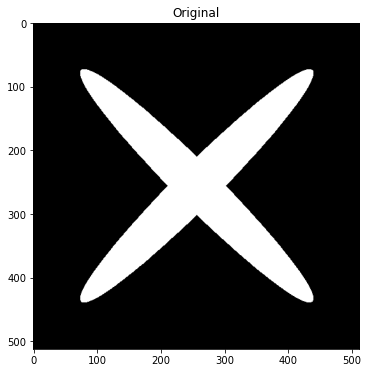

In [2]:
image = cv2.imread('../data/bw.png', cv2.IMREAD_GRAYSCALE)



#######################################################
print_image('Original','image',image,0,2,0,15)
#%pylab inline
plt_view_image(plt,[["Original",image]], figsize=(6,6), axis='on', cmap='gray')

In [3]:
#https://robotclass.ru/tutorials/opencv-python-find-contours/
#Функция OpenCV для поиска контуров findContours() 
#findContours( кадр, режим_группировки, метод_упаковки [, контуры[, иерархия[, сдвиг]]])
#  кадр - должным образом подготовленная для анализа картинка. Это должно быть 8-битное изображение. Поиск контуров 
#         использует для работы монохромное изображение, так что все пиксели картинки с ненулевым цветом будут 
#         интерпретироваться как 1, а все нулевые останутся нулями.
#  режим_группировки — один из четырех режимов группировки найденных контуров: 
#                      CV_RETR_LIST — выдаёт все контуры без группировки; 
#                      CV_RETR_EXTERNAL — выдаёт только крайние внешние контуры; 
#                      CV_RETR_CCOMP — группирует контуры в двухуровневую иерархию. 
#                                      На верхнем уровне — внешние контуры объекта. 
#                                      На втором уровне — контуры отверстий, если таковые имеются. 
#                                      Все остальные контуры попадают на верхний уровень; 
#                      CV_RETR_TREE — группирует контуры в многоуровневую иерархию.
#  метод_упаковки - один из трёх методов упаковки контуров: 
#                   CV_CHAIN_APPROX_NONE — упаковка отсутствует и все контуры хранятся в виде отрезков, состоящих из двух пикселей; 
#                   CV_CHAIN_APPROX_SIMPLE — склеивает все горизонтальные, вертикальные и диагональные контуры; 
#                   CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS — применяет к контурам метод упаковки (аппроксимации) Teh-Chin.
#  контуры — список всех найденных контуров, представленных в виде векторов; 
#  иерархия — информация о топологии контуров. 
#             Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
#  иерархия[i][0] — индекс следующего контура на текущем слое;
#             [i][1] — индекс предыдущего контура на текущем слое:
#                [i][2] — индекс первого контура на вложенном слое;
#                   [i][3] — индекс родительского контура.
#  сдвиг — величина смещения точек контура.

#По состоянию на 2019 год у нас есть три версии OpenCV (OpenCV2, OpenCV3 и OpenCV4).
#OpenCV4 и OpenCV2 имеют похожее поведение (возвращют два значения из cv2.findContours()). 
#Тогда как OpenCV3 возвращает три значения.
#im2, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



#####################################################
for each in contours:
    print("shape =",each.shape)
    for i in range (0,10):
        if i<each.shape[0]:
            print(each[i],end="")
    print()
print("hierarchy",hierarchy)

#contours — список всех найденных контуров, представленных в виде векторов; 
#hierarchy — информация о топологии контуров. 
#Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
#hierarchy[i][0] — индекс следующего контура на текущем слое;
#            [i][1] — индекс предыдущего контура на текущем слое:
#               [i][2] — индекс первого контура на вложенном слое;
#                  [i][3] — индекс родительского контура.


print_image('contours[0]','contours[0]',contours[0],0,3,0,2)
print_image('contours[0]','contours[0]',contours[0],550,556,0,2)

shape = (555, 1, 2)
[[76 74]][[74 76]][[74 84]][[75 85]][[75 87]][[76 88]][[76 89]][[77 90]][[77 92]][[78 93]]
hierarchy [[[-1 -1 -1 -1]]]
------  contours[0]--------------    Shape(555, 1, 2) contours[0]: int32
[ [76 74] ]
[ [74 76] ]
[ [74 84] ]
------  contours[0]--------------    Shape(555, 1, 2) contours[0]: int32
[ [89 76] ]
[ [88 76] ]
[ [87 75] ]
[ [85 75] ]
[ [84 74] ]


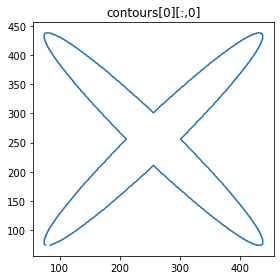

In [4]:
plt.figure(figsize=(4,4))
plt.subplot(111)
plt.axis('on')
plt.title('contours[0][:,0]')
plt.plot(contours[0][:,0][:,0],contours[0][:,0][:,1])
plt.tight_layout()
plt.show()

------  Original-----------------    Shape(512, 512) image: uint8
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 0 0 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 ]
[ 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 ]
------  contours[0]--------------    Shape(555, 1, 2) contours[0]: int32
[ [76 74] ]
[ [74 76] ]
[ [74 84] ]
------  color--------------------    Shape(512, 512, 3) color: uint8
[ [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] ]
[ [0 0 0] [0 0 0] [0 0 0] [0 0 0] [  0 255   0] [  0 255   0] [  0 255   0] [  0 255   0] ]
[ [0 0 0] [0 0 0] [0 0 0] [  0 255   0] [  0 255   0] [  0 255   0] [  0 255   0

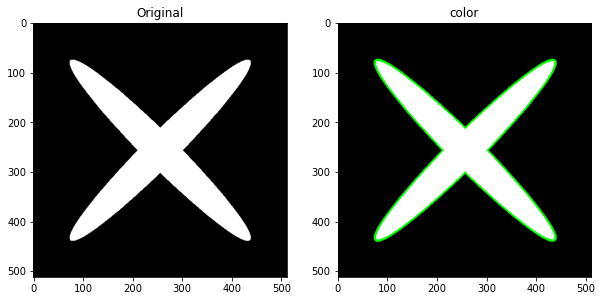

In [5]:
#https://robotclass.ru/tutorials/opencv-python-find-contours/
# Функция для отображения контуров  
#drawContours( кадр, контуры, индекс, цвет[, толщина[, тип_линии[, иерархия[, макс_слой[, сдвиг]]]]])
#  контуры — те самые контуры, найденные функцией findContours() ;
#  индекс — индекс контура, который следует отобразить. -1 — если нужно отобразить все контуры;
#  цвет — цвет контура;
#  толщина — толщина линии контура;
#  тип_линии — тип соединения точек вектора;
#              LINE_8 (or omitted) — 8-connected line.
#              LINE_4 — 4-connected line.
#              LINE_AA — antialiased line.
#  иерархия — информация об иерархии контуров;  иерархия — информация о топологии контуров. 
#             Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i] ;
#  макс_слой — индекс слоя, который следует отображать. 
#              Если параметр равен 0, то будет отображен только выбранный контур. 
#              Если параметр равен 1, то отобразится выбранный контур и все его дочерние контуры. 
#              Если параметр равен 2, то отобразится выбранный контур, все его дочерние и дочерние дочерних!
#  сдвиг — величина смещения точек контура.


color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(color, contours, -1, (0,255,0), 3)


#######################################################
print_image('Original','image',image,73,79,72,100)
print_image('contours[0]','contours[0]',contours[0],0,3,0,2)
print_image('color','color',color,71,79,72,80)
plt_view_image(plt,[["Original",image],["color",color]], figsize=(10,10), axis='on', cmap='gray')

In [6]:
print_image('contours[0]','contours[0]',contours[0],552,556,0,2)
print(contours[0][552:555,-1])
print( (contours[0][::-1])[:3])

------  contours[0]--------------    Shape(555, 1, 2) contours[0]: int32
[ [87 75] ]
[ [85 75] ]
[ [84 74] ]
[[87 75]
 [85 75]
 [84 74]]
[[[84 74]]

 [[85 75]]

 [[87 75]]]


In [7]:
contour = contours[0]

#Contour Area
#Contour area is given by the function cv.contourArea() or from moments, M['m00'].
#http://robocraft.ru/blog/computervision/640.html
#Свойства контуров
# OpenCV предоставляет функции для определения таких полезных свойств найденных контуров, как площадь и длина(периметр).
#  — возвращает площадь контура
#  contour — контур (последовательность или массив вершин)
#  slice — начальная и конечные точки контура (по-умолчанию весь контур)
#            
# ориентация контура влияет на знак, т.о. функция может вернуть отрицательную величину.
# Можно использовать fabs() чтобы получить абсолютное значение площади.

print('Area of contour is %.2f' % cv2.contourArea(contour))
print('Signed area of contour is %.2f' % cv2.contourArea(contour, True))
print('Signed area of contour is %.2f' % cv2.contourArea(contour[::-1], True)) #считаем с конца чтобы получить +++

Area of contour is 47474.00
Signed area of contour is -47474.00
Signed area of contour is 47474.00


In [8]:
#arcLength() — возвращает периметр контура или длину кривой (части контура)
#  curve — последовательность или массив точек кривой (контур)
#  slice — начальная и конечные точки контура (по-умолчанию весь контур)
#         is_closed — определяет закрыта кривая или нет:
#         is_closed = 0 — кривая полагается открытой
#         is_closed > 0 — кривая полагается закрытой
#         is_closed < 0 — если кривая — последовательность, 
#  флаг CV_SEQ_FLAG_CLOSED из ((CvSeq*)curve)->flags проверяется для определения закрыта кривая или нет, 
#  в противном случае (кривая представлена массивом (CvMat*) точек) она полагается открытой.
#  функция считает длину кривой, как сумму длин сегментов между последовательностью точек.


print('Length of closed contour is %.2f' % cv2.arcLength(contour, True))
print('Length of open contour is %.2f' % cv2.arcLength(contour, False))

Length of closed contour is 1905.29
Length of open contour is 1897.29


------  hull---------------------    Shape(11, 1, 2) hull: int32
[ [438 435] ]
[ [437 437] ]
[ [435 438] ]
[ [ 76 438] ]
[ [ 75 437] ]
[ [ 74 435] ]
[ [74 76] ]
[ [76 74] ]
[ [435  74] ]
[ [437  75] ]
[ [438  76] ]


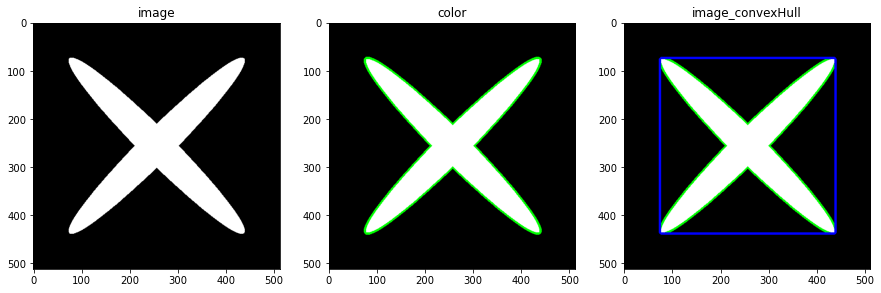

In [9]:
hull = cv2.convexHull(contour)
image_convexHull = cv2.drawContours(np.copy(color), [hull], -1, (0,0,255), 3)


#########################################################
print_image('hull','hull',hull,0,556,0,2)

plt_view_image(plt,[["image",image],["color",color], ["image_convexHull",image_convexHull] ], 
               figsize=(15,10), axis='on', cmap='gray')
cv2.imshow('image, drawContours, image_convexHull', np.hstack([cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), color,image_convexHull   ]))
cv2.waitKey()
cv2.destroyAllWindows()

In [10]:
print('Convex status of contour is %s' % cv2.isContourConvex(contour))
print('Convex status of its hull is %s' % cv2.isContourConvex(hull))

Convex status of contour is False
Convex status of its hull is True


In [11]:
cv2.namedWindow('contours')

img = np.copy(color)

def trackbar_callback(value):
    global img
    epsilon = value*cv2.arcLength(contour, True)*0.1/255
    approx = cv2.approxPolyDP(contour, epsilon, True)
    img = np.copy(color)
    cv2.drawContours(img, [approx], -1, (255,0,255), 3)

cv2.createTrackbar('Epsilon', 'contours', 1, 255, lambda v: trackbar_callback(v))
while True:
    cv2.imshow('contours', img)
    key = cv2.waitKey(3)
    if key == 27: 
        break

cv2.destroyAllWindows()

0
1


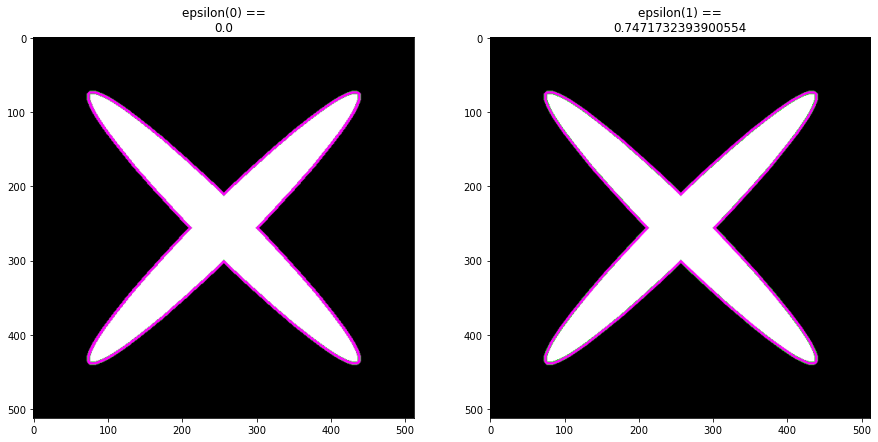

2
3


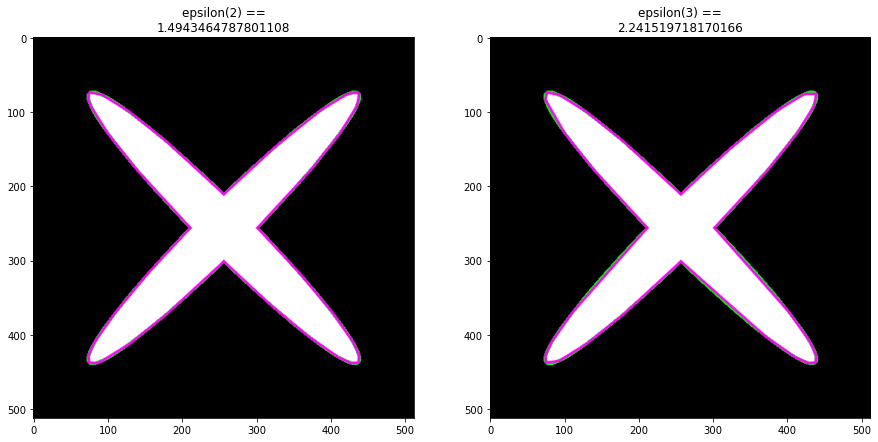

4
5


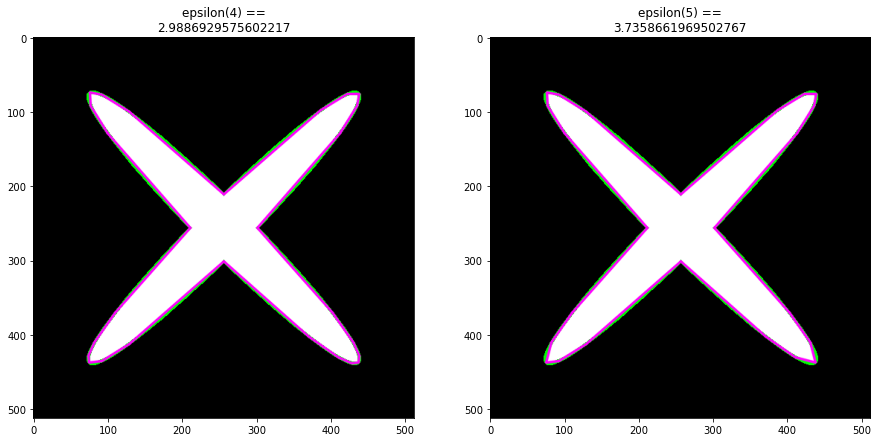

6
7


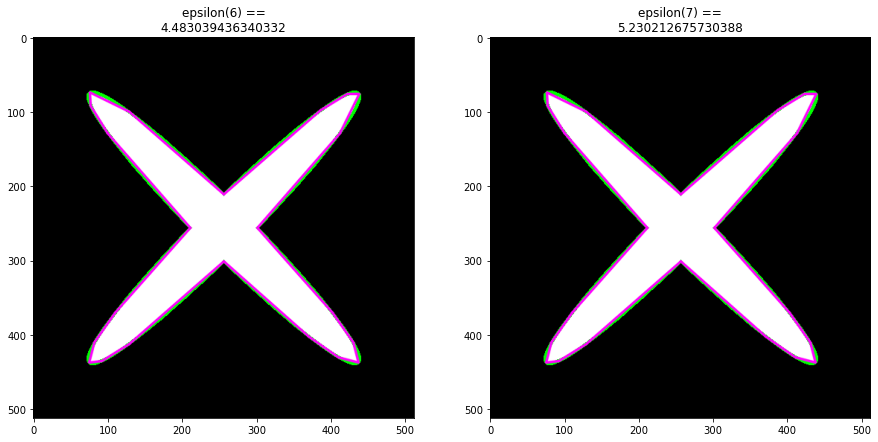

8
9


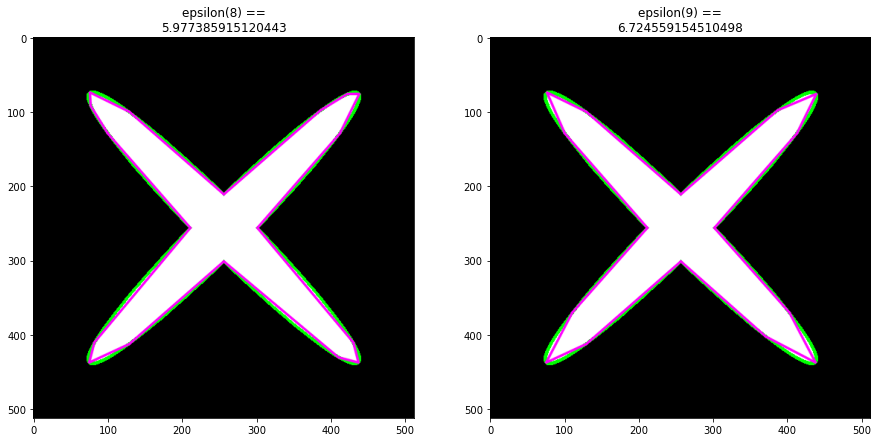

10
11


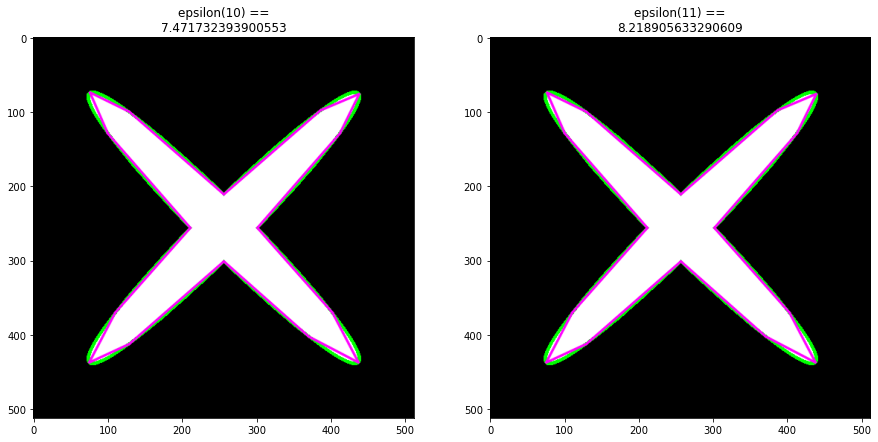

12
13


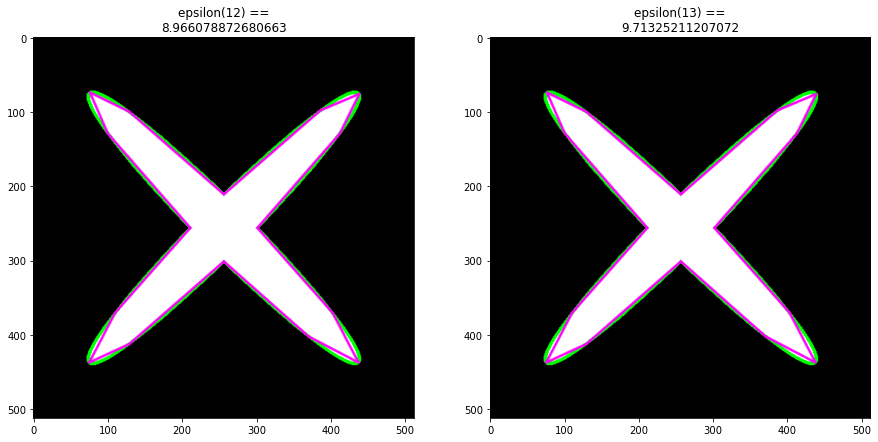

14
15


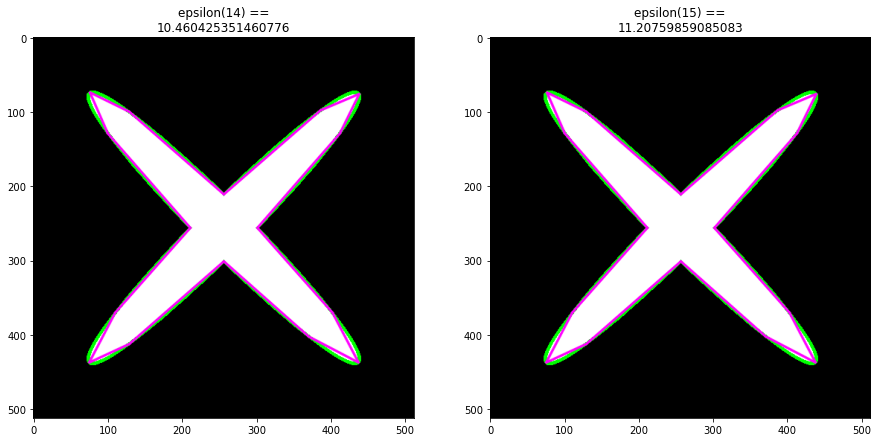

16
17


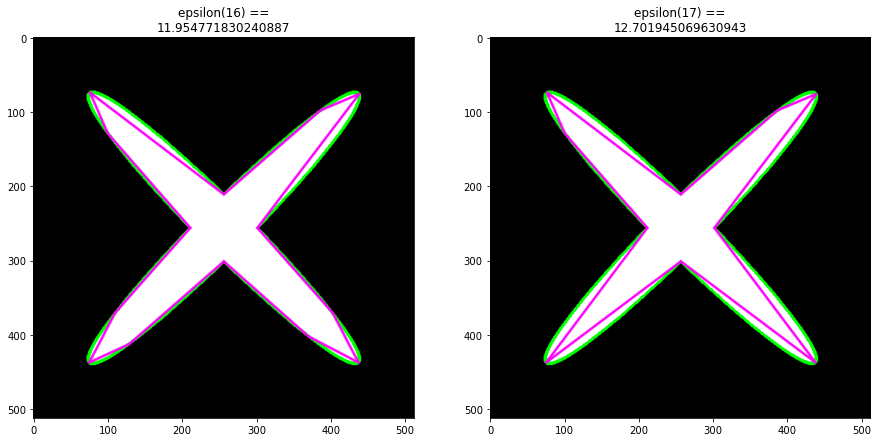

18
19


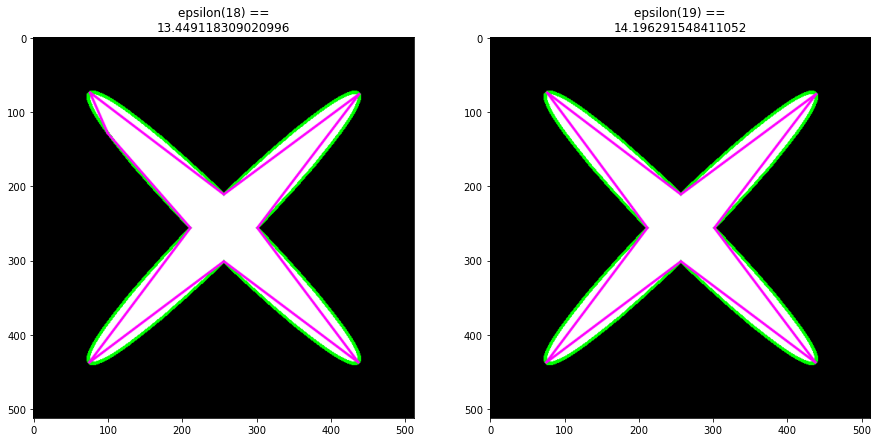

In [12]:
images =[]
count = 0

for i in range(0,20):
    print(i)
    count +=1
    epsilon = i*cv2.arcLength(contour, True)*0.1/255
    approx = cv2.approxPolyDP(contour, epsilon, True)
    img = np.copy(color)
    cv2.drawContours(img, [approx], -1, (255,0,255), 2, lineType=16)#16=='LINE_AA')#lineType=8)
    images.append(['epsilon({0}) ==\n{1}'.format(i,epsilon), img])
    if count %2 ==0:
        plt_view_image(plt,images, figsize=(15,10), axis='on', cmap='gray')
        images =[]
        count =0

50
100


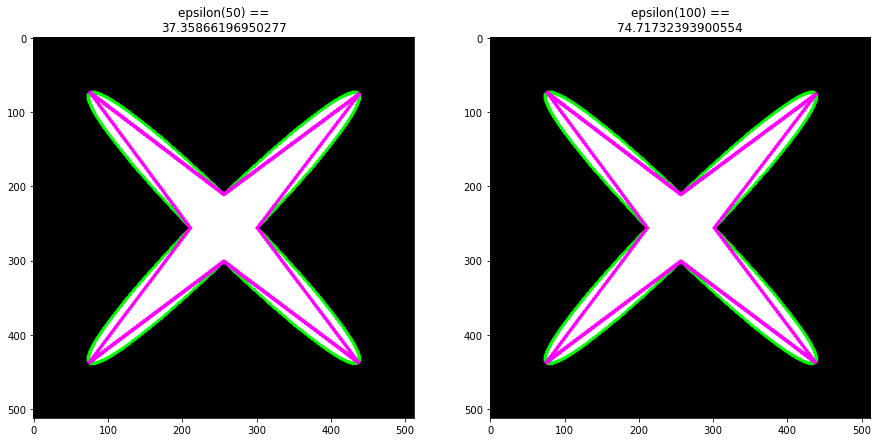

150
200


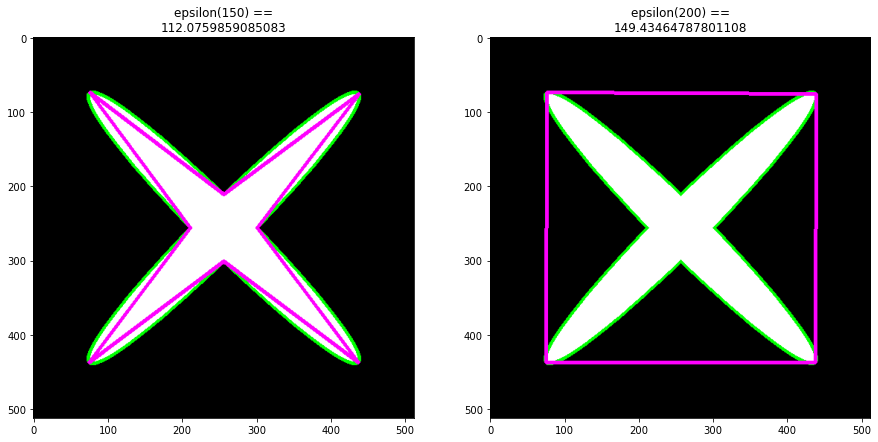

250


In [13]:
images =[]
count = 0

for i in range(50,255, 50):
    print(i)
    count +=1
    epsilon = i*cv2.arcLength(contour, True)*0.1/255
    approx = cv2.approxPolyDP(contour, epsilon, True)
    img = np.copy(color)
    cv2.drawContours(img, [approx], -1, (255,0,255), 3)
    images.append(['epsilon({0}) ==\n{1}'.format(i,epsilon), img])
    if count %2 ==0:
        plt_view_image(plt,images, figsize=(15,10), axis='on', cmap='gray')
        images =[]
        count =0